In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
sns.set_style("darkgrid")

In [3]:
counties=pd.read_csv('counties_storedecline.csv')

## Store Decline

In [3]:
# Split the data
X = counties.drop(['decline', 'FIPS', 'State', 'County',], axis=1)
y = counties['decline']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train.shape # Notice the number of rows in the training set. This should stay constant.

(2507, 20)

In [4]:
# List the features
X.columns

Index(['GROCPTH09', 'WICSPTH08', 'FFRPTH09', 'FSRPTH09', 'PC_FFRSALES07',
       'PC_FSRSALES07', 'PCT_NHWHITE10', 'PCT_65OLDER10', 'PCT_18YOUNGER10',
       'PERPOV10', 'METRO13', 'POPLOSS10', 'MEDHHINC15', 'PCT_LACCESS_POP10',
       'SNAP_PART_RATE08', 'PCT_NSLP09', 'PCT_WIC09', 'PCT_CACFP09',
       'PCT_DIABETES_ADULTS08', 'PCT_OBESE_ADULTS08'],
      dtype='object')

In [5]:
# Random Forest
rf = RandomForestClassifier()
tree_model=rf.fit(X_train, y_train)

In [6]:
# Specify the grid parameters
param_grid = {
        'n_estimators': [100, 150], 
        'max_depth': [3, 4, None],
        'min_samples_split': [5, 10, 15, 100],
        'min_samples_leaf': [5, 10],
#         'max_features': [10, 20, 25, 30], # This is not meaningful because I only have a few predictors
        'class_weight': [None]    
        }

In [7]:
# Grid Search for Best Parameters
grid = GridSearchCV(tree_model, param_grid=param_grid, n_jobs = 1, cv=3)
grid.fit(X_train, y_train);
# We should re-run the RF model with these optimal parameters:
print(grid.best_params_)

{'class_weight': None, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [8]:
# Instantiate and Fit the Model with Optimal Settings
rf = RandomForestClassifier(class_weight= None, 
                            max_depth= 3, 
                            min_samples_leaf= 5, 
                            min_samples_split= 5, 
                            n_estimators= 100)
tree_model=rf.fit(X_train, y_train)

In [9]:
# The crossvalidiation score scores our performance on the training data. 
scores = cross_val_score(tree_model, X_train, y_train, cv=5)
np.mean(scores), np.std(scores) # This is the mean of the 5 cv scores, plus its standard dev.

(0.6038943980825625, 0.010883300856443026)

In [10]:
# Predict the y values on the testing data.
y_hat = tree_model.predict(X_test)
y_hat_probs = tree_model.predict_proba(X_test)[:,1]

## Score the model

In [11]:
# ACCURACY
accuracy=100*metrics.accuracy_score(y_test, y_hat)
print(accuracy)

60.76555023923444


In [12]:
# A confusion matrix tells us our false positives and false negatives:
mat = confusion_matrix(y_test, y_hat)
print (mat)

[[ 59 225]
 [ 21 322]]


In [13]:
# Let's interpret that.
tn, fp, fn, tp = mat.ravel()
sensitivity = 100*tp/(tp+fn)
specificity=100*tn/(tn+fp)
print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 93.87755102040816
specificity: 20.774647887323944


In [14]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
roc_score=100*roc_auc_score(y_test, y_hat_probs)
print(roc_score)

64.23849217755513


## Feature Importance

In [15]:
# compute the feature importances
importances = tree_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.285118)
2. feature 7 (0.100140)
3. feature 2 (0.084287)
4. feature 6 (0.082311)
5. feature 3 (0.080921)
6. feature 8 (0.073001)
7. feature 13 (0.053684)
8. feature 19 (0.039701)
9. feature 12 (0.035882)
10. feature 1 (0.029731)
11. feature 14 (0.025057)
12. feature 18 (0.021510)
13. feature 4 (0.018541)
14. feature 5 (0.017559)
15. feature 15 (0.015114)
16. feature 11 (0.014716)
17. feature 16 (0.011206)
18. feature 17 (0.009490)
19. feature 10 (0.001626)
20. feature 9 (0.000404)


In [16]:
# List the features by importance:
feat_imp=pd.DataFrame(importances, index=X_test.columns, columns=['importance'])
feat_imp['importance'].sort_values(ascending=False).head(10)

GROCPTH09             0.285118
PCT_65OLDER10         0.100140
FFRPTH09              0.084287
PCT_NHWHITE10         0.082311
FSRPTH09              0.080921
PCT_18YOUNGER10       0.073001
PCT_LACCESS_POP10     0.053684
PCT_OBESE_ADULTS08    0.039701
MEDHHINC15            0.035882
WICSPTH08             0.029731
Name: importance, dtype: float64

In [17]:
top10=pd.DataFrame(feat_imp['importance'].sort_values(ascending=False).head(10))

Text(0,0.5,'Feature Importance')

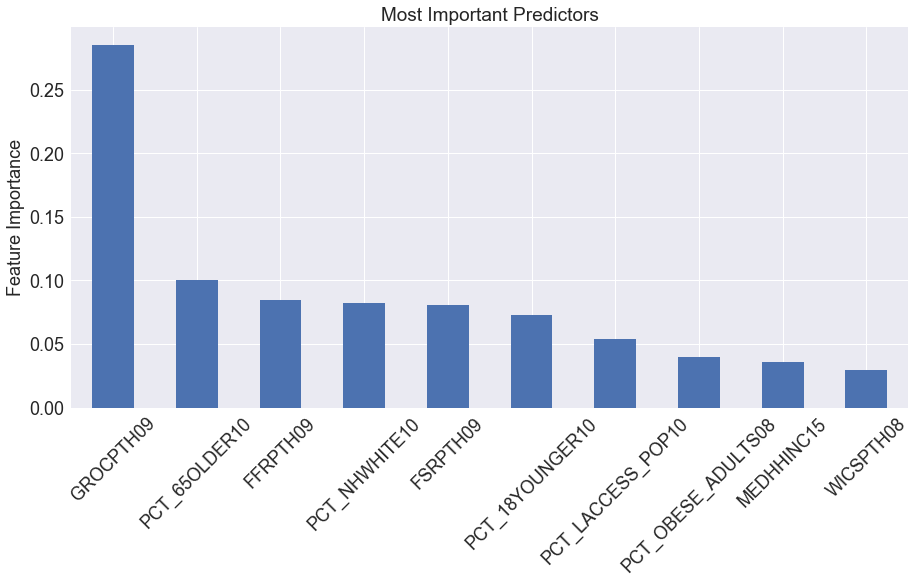

In [18]:
sns.set(style="darkgrid", color_codes=None)
# sns.palplot(sns.color_palette("RdBu", n_colors=7))
ax = top10.plot(kind='bar', legend=False, fontsize=18,  figsize=(15, 7))
plt.xticks(rotation = 45,  fontsize=18)
plt.title('Most Important Predictors',  fontsize=19)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Feature Importance', rotation=90,  fontsize=18)

## ROC-AUC Score

In [19]:
from sklearn.metrics import roc_curve, auc

In [20]:
# Empty dictionaries.
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For class 1 (has WNV), find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, y_hat_probs)
ROC_AUC[1] = auc(FPR[1], TPR[1])

In [21]:
# What is that ROC-AUC score?
print(ROC_AUC[1])
# Same but using the scikit default:
roc_auc_score(y_test, y_hat_probs)

0.6423849217755513


0.6423849217755513

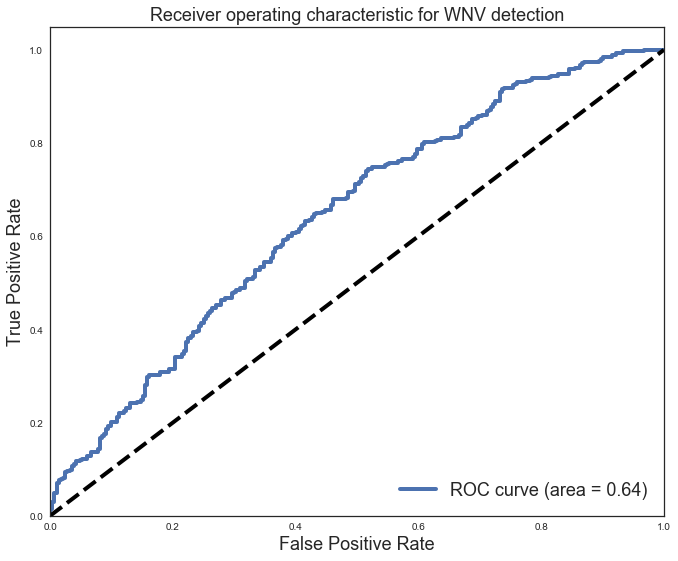

In [22]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV detection', fontsize=18)
plt.legend(loc="lower right", fontsize=18);